# 1. Daten Laden

In [13]:
# Bibliotheken laden
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://github.com/sebastianiu/Prognosemodell_Online_Kreditzahlungsverkehr/raw/main/data/raw/PSP_Jan_Feb_2019.xlsx"
Datensatz = pd.read_excel(url)
Datensatz = Datensatz.rename(columns = {"Unnamed: 0":"id"})

# 2. Datenaufbereitung & Bewertungsfunktionen

In [65]:
# Bilbiotheken laden
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import  roc_curve,auc,accuracy_score, confusion_matrix, f1_score,log_loss
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score

def Visualisierung_AUC(model,x_test,y_test):
  # Berechnung der Falsch-Positiv-Rate und der Wahr-Positiv-Rate für alle Schwellenwerte der Klassifizierung
  probs = model.predict_proba(x_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  # Visualisierung
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def Visualisierung_Class_Errors(model,x_test,y_test):
  #Vorhersage
  y_pred = model.predict(x_test)
  #Zippe Daten in Liste
  list(zip(y_pred,y_test))
  #Entzippe Liste
  unzip_file = [{'y_pred':y_pred,'y_test':y_test}for y_pred,y_test in zip(y_pred,y_test)]
  #Estelle DataFrame
  data = pd.DataFrame(unzip_file)
  #Ermittel Classification Error
  data['class_error'] = abs(data.y_pred-data.y_test)
  data = pd.concat([data,x_test], axis=1, join="inner")
  data['zaehler'] = 1

  # Decode Features
  data['PSP'] = label_encoder_PSP.inverse_transform(data['PSP'])
  data['country'] = label_encoder_country.inverse_transform(data['country'])
  data['card'] = label_encoder_card.inverse_transform(data['card'])
  data['weekday'] = label_encoder_weekday.inverse_transform(data['weekday'])

  max = data.amount.max()

  def create_amount_quantiles(row):
    if row['amount'] > 0 and row['amount'] <= max/4:
      result = '0 - '+str(max/4)
    else:
      if row['amount'] > max/4 and row['amount'] <= max/4*2:
        result = str(max/4+1)+' - '+str(max/4*2)
      else:
        if row['amount'] > max/4*2 and row['amount'] <= max/4*3:
          result = str(max/4*2+1)+' - '+str(max/4*3)
        else:
          result = str(max/4*3+1)+' - '+str(max)
    return result

  data['amount_quantiles'] = data.apply(create_amount_quantiles, axis=1)


  field_list = ['PSP','card','country','weekday','3D_secured','amount_quantiles']
  error_rates = pd.DataFrame(columns=['Merkmal','Merkmalswert','class_error','zaehler'])

  for field in field_list:
    errors = data.groupby(data[field])['class_error'].sum()
    total = data.groupby(data[field])['zaehler'].sum()
    error_rates_tmp = pd.concat([errors, total], axis=1)
    error_rates_tmp['Merkmalswert'] = error_rates_tmp.index.values
    error_rates_tmp['Merkmal']=field
    error_rates_tmp.reset_index()
    error_rates = pd.concat([error_rates,error_rates_tmp])

  error_rates['class_error_rate'] = error_rates.zaehler/error_rates.class_error
  max_error_rate = error_rates['class_error_rate'].max()

  # Visualisiere Verteilungen
  fig = px.bar(error_rates, x='Merkmalswert', y='class_error_rate', color= 'Merkmal',labels={'class_error_rate':'Klassifizierungsfehler in %'},title="Fehlerrate Klassifizierungen")
  fig.add_hline(y=max_error_rate,line_dash="dot",annotation_text=str(round(max_error_rate,2))+' %',annotation_position="top left")
  fig.show()

def Model_Bewertung(model,x_train, y_train,x_test, y_test,X,Y):
  y_pred_proba = model.predict_proba(x_test)
  cross_validation_tmp = cross_val_score(model, X, Y, cv=6)
  cross_validation=[]
  for value in cross_validation_tmp:
    new = round(value,3)
    cross_validation.append(new)

  #Vorhersagen für Bewertung erzeugen
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)

  print('Bewertungsmetriken')
  print('#'*20)
  print(f"Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(accuracy_score(y_train, y_train_pred),2)}")
  print(f"Vorhersage-Genauigkeit auf Basis der Testdaten: {round(accuracy_score(y_test, y_test_pred),2)}")
  print('*'*15)
  f1_score_train = round(f1_score(y_train_pred,y_train,zero_division=1.0,average='weighted'),2)
  f1_score_test = round(f1_score(y_test_pred,y_test,zero_division=1.0,average='weighted'),2)
  print(f"F1-Score auf Basis der Trainingsdaten: {f1_score_train}")
  print(f"F1-Score auf Basis der Testdaten: {f1_score_test}")
  print('*'*15)
  print(f"Vorhersage-Genauigkeit nach Kreuz-Validierung: {round(sum(cross_validation)/len(cross_validation),2)}")
  print('*'*15)
  print(f"Binary Cross-Entropy auf Basis der Trainingsdaten: {log_loss(y_train, model.predict_proba(x_train))}")
  print(f"Binary Cross-Entropy auf Basis der Testdaten: {log_loss(y_test, model.predict_proba(x_test))}")
  print('*'*15)

# Datenaufbereitung
label_encoder_PSP = LabelEncoder()
label_encoder_country = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_weekday = LabelEncoder()

ML_Daten = Datensatz.filter(['amount','success','PSP','country','card','tmsp','3D_secured'], axis=1)

ML_Daten['country'] = label_encoder_country.fit_transform(ML_Daten['country'])
ML_Daten['PSP'] = label_encoder_PSP.fit_transform(ML_Daten['PSP'])
ML_Daten['card'] = label_encoder_card.fit_transform(ML_Daten['card'])

# Datumswerte in Tag/ Wochentag/ Stunde aufteilen
ML_Daten['weekday'] = ML_Daten['tmsp'].dt.day_name()
ML_Daten['weekday'] = label_encoder_weekday.fit_transform(ML_Daten['weekday'])
ML_Daten['day'] = ML_Daten['tmsp'].dt.strftime('%d').astype(int)
ML_Daten['hour'] = ML_Daten['tmsp'].dt.strftime('%H').astype(int)

# Separation in X Merkmale and Zielvariable Y
Y = ML_Daten['success']
X = ML_Daten.filter(['amount','PSP','3D_secured','card','country','weekday','day','hour'], axis=1)

# Aufteilung in Trainings- und Validierungsdatensatz
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# 3 RandomForest Classifier- Testen & Bewerten

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.96
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.76
***************
F1-Score auf Basis der Trainingsdaten: 0.96
F1-Score auf Basis der Testdaten: 0.81
***************
Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.79
***************
Binary Cross-Entropy auf Basis der Trainingsdaten: 0.15749854165155186
Binary Cross-Entropy auf Basis der Testdaten: 0.6213108596860498
***************


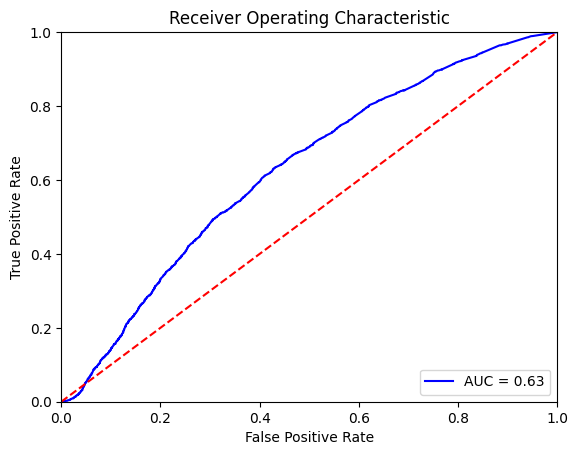

In [66]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

Model_Bewertung(rfc,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(rfc,x_test,y_test)
Visualisierung_Class_Errors(rfc,x_test,y_test)



# 4 Logistische Regression Testen & Bewerten

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.8
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.79
***************
F1-Score auf Basis der Trainingsdaten: 0.89
F1-Score auf Basis der Testdaten: 0.89
***************
Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.8
***************
Binary Cross-Entropy auf Basis der Trainingsdaten: 0.5060621037090394
Binary Cross-Entropy auf Basis der Testdaten: 0.5105155074067632
***************


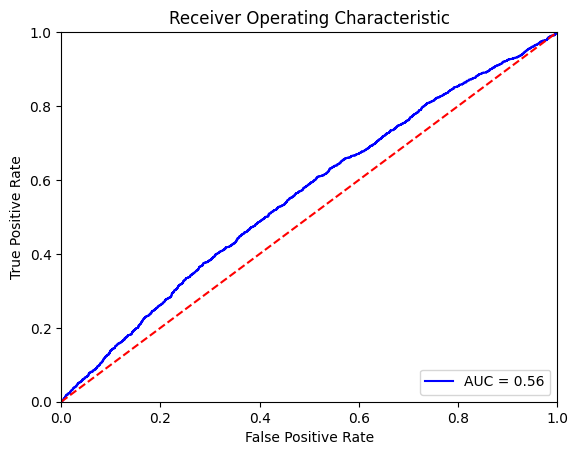

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

x_train_scaled = preprocessing.StandardScaler().fit(x_train)

lg = LogisticRegression(max_iter=10)
lg.fit(x_train, y_train)

Model_Bewertung(lg,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(lg,x_test,y_test)
Visualisierung_Class_Errors(lg,x_test,y_test)

# 5. K-Nearest Neighbour Testen & Bewerten

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.82
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.77
***************
F1-Score auf Basis der Trainingsdaten: 0.86
F1-Score auf Basis der Testdaten: 0.83
***************
Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.76
***************
Binary Cross-Entropy auf Basis der Trainingsdaten: 0.3689136261693503
Binary Cross-Entropy auf Basis der Testdaten: 2.951084772560507
***************


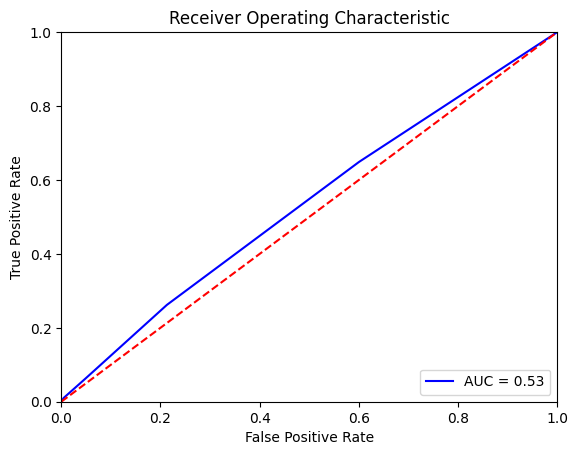

In [68]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

Model_Bewertung(KNN,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(KNN,x_test,y_test)
Visualisierung_Class_Errors(KNN,x_test,y_test)

# 6. DecisionTreeClassifier Testen & Bewerten

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.96
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.72
***************
F1-Score auf Basis der Trainingsdaten: 0.96
F1-Score auf Basis der Testdaten: 0.73
***************
Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.68
***************
Binary Cross-Entropy auf Basis der Trainingsdaten: 0.0627637787722627
Binary Cross-Entropy auf Basis der Testdaten: 9.92430364512252
***************


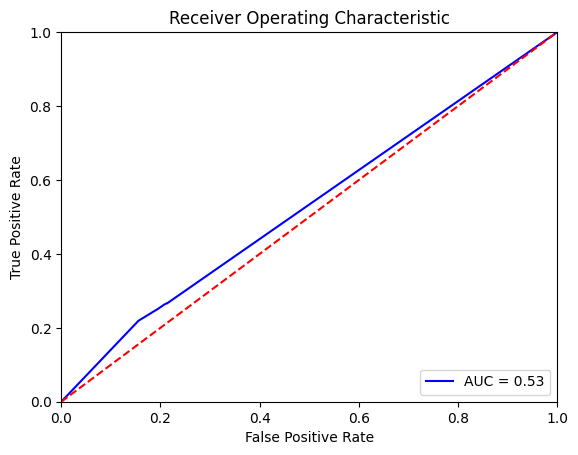

In [72]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(x_train, y_train)

Model_Bewertung(DTC,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(DTC,x_test,y_test)
Visualisierung_Class_Errors(DTC,x_test,y_test)

# 7. XGBoost Classifier Testen & Bewerten


Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.83
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.79
***************
F1-Score auf Basis der Trainingsdaten: 0.88
F1-Score auf Basis der Testdaten: 0.86
***************
Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.77
***************
Binary Cross-Entropy auf Basis der Trainingsdaten: 0.3876037783133495
Binary Cross-Entropy auf Basis der Testdaten: 0.49259908463942886
***************


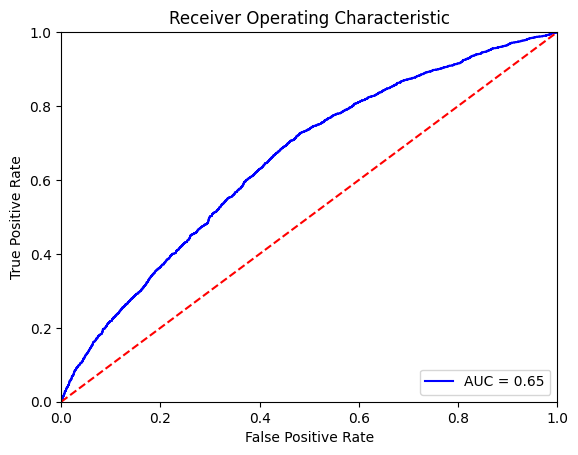

In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Modell erstellen und trainieren
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

# Metriken berechnen
Model_Bewertung(xgb,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(xgb,x_test,y_test)
Visualisierung_Class_Errors(xgb,x_test,y_test)